<a href="https://colab.research.google.com/github/tluxxx/weekly-pattern-in-stock-markets/blob/main/weekly_patterns_(part_2_N_weeks_cycle_with_optimized_pattern).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploiting weekly patterns in stock market for trading
#### part II: optimizing the pattern within a cycle

This series is based on a strategy-idea originally generated by Thomas Gebert (Kurzfrist-Strategien fuer Anleger, Boersenbuchverlag, 2020). The original strategy was tested and expanded. Further modifications are investigated. The modifications in this part are as follows:

1.   Detecting patterns  
1.   optimizing the pattern within a 16-weeks-cycle using genetic algorithms (GA)
3.   extending the analyses to N-weeks-cycles (N = [4, 52]) and optimizing patterns within each cycle, using GA

#1. Preparation & Data Upload

In [ ]:
# loading external packages
!pip install pygad

# preparation
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/weekly_pattern')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
# importing all standard modules
import pandas as pd, numpy as np, yfinance as yf, numba as nb
import pygad, importlib
import plotly.express as px, plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from tabulate import tabulate
from warnings import filterwarnings
from numba import jit
filterwarnings('ignore')

In [ ]:
# importing customized modules
from helpers_pattern_01 import *

In [ ]:
# re-importing customized modules (if required)
import helpers_pattern_01
importlib.reload(helpers_pattern_01)
from helpers_pattern_01 import *

In [ ]:
# direct download price dataframe from yfinance
end_date = '2024-03-30'
start_date = '2000-01-01'
price = yf.download('^GDAXI', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# 2. Optimizing the weekly pattern within a 16-weeks cycle



## 2.1. Original Period [2000- 2018]

###2.1.1. General Preparations and Settings

In [ ]:
# main parameter settings:
pos_orig = [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 1, 1, 1, -1]
n = 16
shift_weeks = 12
limits =[(0.5,-0.5), (0.3,-0.3), (0.2,-0.2), (0,0)]  # parameters for pattern detection algorithm

# assumtion concerning equity and fee
start_equity = 10000                  # equity at start
fee = 0.0025                          # 0.25% of equity per trade
fixed_fee = 4.9                       # 4.9 EUR per trade

In [ ]:
# transforming daily into weekly data and setting parameters for [2000-2018]
price_w = transforming_daily_weekly(price, mode='open')
price_w_orig = price_w[price_w.index < '2018-12-31']    # timeframe of original study
price_w_rec = price_w[price_w.index > '2018-12-31']     # timeframe for outer years
pos = pos_weekly(price_w_orig, pos_orig, shift_weeks)

In [ ]:
# check if 2018-11-12 is in week_type 4
week_type = (price_w_orig['week_nb'] + shift_weeks) % len(pos_orig)
week_type[week_type.index=='2018-11-12']

start_w
2018-11-12    4
Name: week_nb, dtype: int64

###2.1.2. Manual Pattern Detection

In [ ]:
# returns per type of week
main_title = 'Average returns (%) per week type in 16 weeks-cycle (w/o fees)'
sub_title = 'instrument: DAX [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# calculations
df1, pos_x  = pattern_detection(price_w_orig, n, upper_limit=limits[0][0], lower_limit=limits[0][1])

# plotting and printing
fig = go.Figure()
fig.add_trace(go.Bar(x=list(df1.index),y=list(df1), name='orig. period'))
fig.add_hline(y=limits[0][0], line_dash="dot", annotation_text=f'limit LONG = {limits[0][0]}', annotation_position='bottom right', line_color='yellow')
fig.add_hline(y=limits[0][1], line_dash="dot", annotation_text=f'limit SHORT = {limits[0][1]}', annotation_position='top left', line_color='yellow')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='week_type', yaxis_title='average return (%)')
fig.update_xaxes(dtick=1)
fig.show()
print('***************************************')
print(f'detected pattern:  {pos_x}')

***************************************
detected pattern:  [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]


In [ ]:
# comparison original pattern and detected pattern
main_title = 'Pattern of trading Positions original pattern and detected pattern'
sub_title = '1= LONG, -1 = SHORT, 0 = FLAT'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# detected pattern and original pattern shifted by shift_weeks
pos_orig_opt11 = pos_x
xx = np.roll(np.array(pos_orig), -shift_weeks).tolist()

# plotting
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(0,n)), y=pos_orig_opt11, name=f'detected pattern {limits[0]}'))
fig.add_trace(go.Bar(x=list(range(0,n)), y=xx, name='original pattern, shiftetd by 12 weeks'))
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=300)
fig.update_layout(title=title, xaxis_title="week_type", yaxis_title='Position')
fig.update_xaxes(dtick=1)
fig.show()

print(f'*******************************************************************')
print(f'detected pattern, limits={limits[0]}:                  {pos_orig_opt11}')
print(f'original pattern (shifted by shift_weeks = 12):        {xx}')
print(f'original pattern:                                      {pos_orig} ')

*******************************************************************
detected pattern, limits=(0.5, -0.5):                  [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]
original pattern (shifted by shift_weeks = 12):        [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0]
original pattern:                                      [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 1, 1, 1, -1] 


In [ ]:
# plotting of manually optimized results and comparing to the original pattern
main_title = f'PnL for 16-weeks-cycle, detected pattern (limits={limits[0]}) vs. original pattern vs. B&H (w/o fees)'
sub_title = 'instrument: DAX [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# calculations for optimized/original pattern and buy & hold
pnl_orig_opt11 = pnl_accumulation(price_w_orig,
                                  pos_weekly(price_w_orig, pos_orig_opt11, shift=0))
pnl_orig = pnl_accumulation(price_w_orig,
                            pos_weekly(price_w_orig, pos_orig, shift=shift_weeks))
pnl_orig_buh = (1 + price_w_orig['price'].pct_change()).cumprod()

# plotting/printing
fig = go.Figure()
fig.add_trace(go.Scatter(x=pnl_orig_opt11.index, y=pnl_orig_opt11, name=f'detected pattern limits={limits[0]}'))
fig.add_trace(go.Scatter(x=pnl_orig.index, y=pnl_orig, name='original pattern'))
fig.add_trace(go.Scatter(x=pnl_orig_buh.index, y=pnl_orig_buh, name='Buy & Hold'))
fig.update_layout(template = 'plotly_dark', autosize=False,width=1200,height=600)
fig.update_layout(title=title, xaxis_title="Date", yaxis_title='PnL')
fig.show()

print(' ')
print('******************************************************')
print(f'Results detected pattern limits={limits[0]}:        {pnl_orig_opt11[-1]:.2f} ')
print(f'Results original pattern:                           {pnl_orig[-1]:.2f} ')
print(f'Results Buy & Hold:                                 {pnl_orig_buh[-1]:.2f} ')


 
******************************************************
Results detected pattern limits=(0.5, -0.5):        33.52 
Results original pattern:                           22.74 
Results Buy & Hold:                                 1.52 


###2.1.3. Advanced optimisation using genetic algorithms (GA) (maximizing final PnL-values)

In [ ]:
# GA specific section

# function to be optimized via GA --> final pnl-values --> max
def opt_pattern1(ga_instance, pos_run, pos_run_idx):
  pnl_run_opt = pnl_accumulation(pr_w_run_opt,
                                 pos_weekly(pr_w_run_opt, pos_run, shift=0))
  return pnl_run_opt[-1]

# definition of GA-instance
ga_instance = pygad.GA(num_generations=80,
                       num_parents_mating=4,
                       fitness_func=opt_pattern1,
                       sol_per_pop=8,
                       num_genes=n,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)

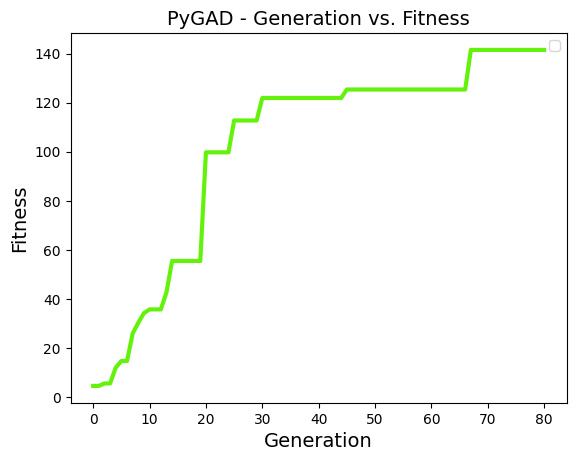

**************************************************
 GA-optimized pattern (max PnL):  [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1]
 PnL of GA-optimized pattern:     141.50


In [ ]:
# performing GA-optimisation, plotting fittnes function
pr_w_run_opt = price_w_orig
ga_instance.run()
fig = ga_instance.plot_fitness()

# optimized pattern and best-fittnes-function value for 16 wks-cycle
pos_orig_opt2, strat, strat_idx = ga_instance.best_solution()

print('**************************************************')
print(f' GA-optimized pattern (max PnL):  {pos_orig_opt2.tolist()}')
print(f' PnL of GA-optimized pattern:     {strat:.2f}')

In [ ]:
# comparison original pattern and manually optimized pattern
main_title = 'Pattern of trading positions GA optimized patterns and detected'
sub_title = '1= LONG, -1 = SHORT, 0 = FLAT'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# detected patterns
df_x, pos_orig_opt12  = pattern_detection(price_w_orig, n,
                                          upper_limit=limits[3][0],
                                          lower_limit=limits[3][1])

# plotting
fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(0,n)), y=pos_orig_opt12, name=f'manually optimized pattern {limits[3]}'))
fig.add_trace(go.Bar(x=list(range(0,n)), y=pos_orig_opt2, name='GA optimized pattern-I'))
fig.update_layout(template='plotly_dark', autosize=False, width=1200, height=300)
fig.update_layout(title=title, xaxis_title="week_type", yaxis_title='Position')
fig.update_xaxes(dtick=1)
fig.show()

print(f'*******************************************************************')
print(f'detected pattern, limits = {limits[3]}:            {pos_orig_opt12} ')
print(f'GA-optimized pattern-I (max PnL):             {pos_orig_opt2.tolist()}')


*******************************************************************
detected pattern, limits = (0, 0):            [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1] 
GA-optimized pattern-I (max PnL):             [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1]


In [ ]:
# plotting of optimized results and comparing to the original pattern
main_title = 'PnL for 16-weeks-cycle, various patterns (GA-optimized, detected, original) vs. B&H) (w/o fees)'
sub_title = 'instrument: DAX [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# calculations for GA optimized pattern I (max PnL)
pnl_orig_opt2 = pnl_accumulation(price_w_orig,
                                 pos_weekly(price_w_orig, pos_orig_opt2, shift=0))

# plotting/printing
fig = go.Figure()
fig.add_trace(go.Scatter(x=pnl_orig_opt2.index, y=pnl_orig_opt2, name=f'GA-opt.-pattern-I (max PnL) = detected pattern {limits[3]}'))
fig.add_trace(go.Scatter(x=pnl_orig_opt11.index, y=pnl_orig_opt11, name=f'detected pattern {limits[0]}'))
fig.add_trace(go.Scatter(x=pnl_orig.index, y=pnl_orig, name='original pattern'))
fig.add_trace(go.Scatter(x=pnl_orig_buh.index, y=pnl_orig_buh, name='Buy & Hold'))
fig.update_layout(title=title)
fig.update_layout(autosize=False,width=1200,height=600)
fig.update_layout(template = 'plotly_dark', xaxis_title="Date", yaxis_title='PnL')
fig.show()

print(' ')
print('******************************************************************************')

print(f'final PnL GA optimized pattern-I (max PnL) = detected pattern {limits[3]}:              {pnl_orig_opt2[-1]:.2f}')
print(f'final PnL detected pattern {limits[0]}:                                            {pnl_orig_opt11[-1]:.2f}')
print(f'Final PnL original pattern:                                                        {pnl_orig[-1]:.2f}')
print(f'final PnL Buy & Hold:                                                              {pnl_orig_buh[-1]:.2f}')

 
******************************************************************************
final PnL GA optimized pattern-I (max PnL) = detected pattern (0, 0):              141.50
final PnL detected pattern (0.5, -0.5):                                            33.52
Final PnL original pattern:                                                        22.74
final PnL Buy & Hold:                                                              1.52


In [ ]:
# Equity curves including fees
main_title = 'Equity curve 16-weeks-cycle, various patterns (GA-optimized, detected, original) (w fees))'
sub_title = 'instrument: DAX [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# GA-optimized pattern I (max PnL) --> positions, trades, equity
ps_orig_opt2 = pos_weekly(price_w_orig, pos_orig_opt2, shift=0)
trades_orig_opt2 = trading_journal(price_w_orig, ps_orig_opt2)
eq_orig_opt2 = pnl_acc_real_equity(price_w_orig, ps_orig_opt2, start_equity, fee, fixed_fee)

# detected pattern --> positions, trades, equity
ps_orig_opt11 = pos_weekly(price_w_orig, pos_orig_opt11, shift=0)
trades_orig_opt1 = trading_journal(price_w_orig, ps_orig_opt11)
eq_orig_opt11 = pnl_acc_real_equity(price_w_orig, ps_orig_opt11, start_equity, fee, fixed_fee)

# original pattern --> positions, trades, equity
ps_orig_orig = pos_weekly(price_w_orig, pos_orig, shift=shift_weeks)
trades_orig_orig = trading_journal(price_w_orig, ps_orig_orig)
eq_orig_orig = pnl_acc_real_equity(price_w_orig, ps_orig_orig, start_equity, fee, fixed_fee)


# plotting/printing
fig = go.Figure()
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_opt2, name=f'GA-opt.-pattern-I (max PnL) = detected pattern {limits[3]}'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_opt11, name=f'detected pattern {limits[0]}'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_orig, name='orig. pattern'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=pnl_orig_buh * start_equity, name='Buy and Hold'))

fig.update_layout(title=title, xaxis_title='date', yaxis_title='Equity')
fig.update_layout(autosize=False, width=1200, height=600, template = 'plotly_dark' )
fig.show()

print(' ')
print('******************************************************************************')
print(f'Final Equity GA-opt.-pattern-I (max PnL) = dtected pattern {limits[3]}:                  {eq_orig_opt2[-1]:,.1f}   =  {eq_orig_opt2[-1]/start_equity*100:.2f} %      number of trades: {len(trades_orig_opt2)}')
print(f'Final Equity detected pattern {limits[0]}:                                          {eq_orig_opt11[-1]:,.1f}   =  {eq_orig_opt11[-1]/start_equity*100:.2f} %      number of trades: {len(trades_orig_opt1)}')
print(f'Final Equity original pattern:                                                      {eq_orig_orig[-1]:,.1f}   =  {eq_orig_orig[-1]/start_equity*100:.2f} %      number of trades: {len(trades_orig_orig)}')
print(f'Final Equity Buy & Hold:                                                            {pnl_orig_buh[-1] * start_equity:,.1f}   =  {pnl_orig_buh[-1]*100:.2f} % ')


 
******************************************************************************
Final Equity GA-opt.-pattern-I (max PnL) = dtected pattern (0, 0):                  98,799.6   =  988.00 %      number of trades: 496
Final Equity detected pattern (0.5, -0.5):                                          88,706.4   =  887.06 %      number of trades: 248
Final Equity original pattern:                                                      59,026.0   =  590.26 %      number of trades: 248
Final Equity Buy & Hold:                                                            15,236.8   =  152.37 % 


###2.1.4. Advanced optimisation using GA (maximize final equity (=w fee))

In [ ]:
# optimisation of final equity (w fee)

# function to be optimized via GA --> final equity --> max
def opt_pattern2(ga_instance, pos_run, pos_run_idx):
  eq_run = pnl_acc_real_equity(pr_w_run,
                               pos_weekly(pr_w_run, pos_run, shift=0),
                               start_equity, fee, fixed_fee)
  return eq_run[-1]

# definition of GA-instance
ga_instance = pygad.GA(num_generations=120,
                       num_parents_mating=4,
                       fitness_func=opt_pattern2,
                       sol_per_pop=8,
                       num_genes=n,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)

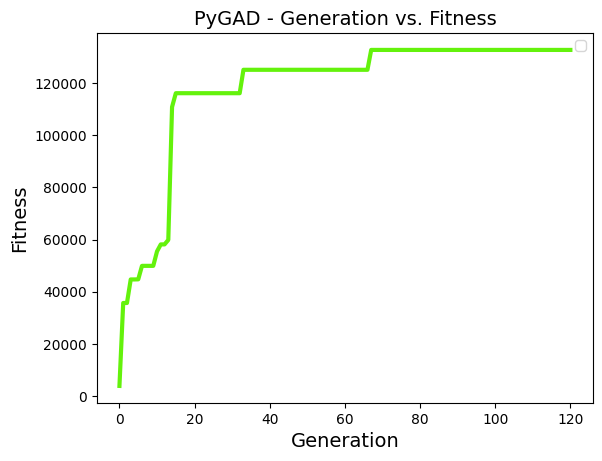

**************************************************
 optimal pattern in 16-weeks-cycle (w fee): [1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, -1, -1]
 total return of optimal pattern (w fee):   132,684.93


In [ ]:
# performing GA-optimisation, plotting fittnes function (maximum final equity)
pr_w_run = price_w_orig
ga_instance.run()
fig = ga_instance.plot_fitness()

# optimized pattern and best-fittnes-function value for 16 wks-cycle
pos_orig_opt3, strat, strat_idx = ga_instance.best_solution()

print('**************************************************')
print(f' optimal pattern in 16-weeks-cycle (w fee): {pos_orig_opt3.tolist()}')
print(f' total return of optimal pattern (w fee):   {strat:,.2f}')

In [ ]:
# comparison GA-optimized pattern (w fee) and GA optimized pattern (w/o fee)

print(f'*******************************************************************')
print(f'GA-optimized pattern II (max final equity = w fees):      {pos_orig_opt3.tolist()}')
print(f'GA-optimized pattern I  (max PnL = w/o fees):             {pos_orig_opt2.tolist()} ')
print(f'detected  pattern {limits[0]}:                            {pos_orig_opt11}')

*******************************************************************
GA-optimized pattern II (max final equity = w fees):      [1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, -1, -1]
GA-optimized pattern I  (max PnL = w/o fees):             [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1] 
detected  pattern (0.5, -0.5):                            [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]


In [ ]:
# Equity curves including fees
main_title = f'Equity curve 16-weeks-cycle, various patterns (GA-optimized-II, GA-optimized-I, detected {limits[0]}, original) (w fees)'
sub_title = 'instrument: DAX [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# GA opt.patter II (max final equity) --> positions, trades, equity
ps_orig_opt3 = pos_weekly(price_w_orig, pos_orig_opt3, shift=0)
trades_orig_opt3 = trading_journal(price_w_orig, ps_orig_opt3)
eq_orig_opt3 = pnl_acc_real_equity(price_w_orig, ps_orig_opt3, start_equity, fee, fixed_fee)

# plotting results
fig = go.Figure()
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_opt3, name='GA-opt.-pattern-II (max final equity)'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_opt2, name='GA-opt.-pattern-I (max PnL)'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_opt11, name=f'manually optimized pattern {limits[0]}'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=eq_orig_orig, name='original pattern'))
fig.add_trace(go.Scatter(x=price_w_orig.index, y=pnl_orig_buh * start_equity, name='Buy and Hold'))

fig.update_layout(title=title, xaxis_title='date', yaxis_title='Equity')
fig.update_layout(autosize=False, width=1200, height=600, template = 'plotly_dark' )
fig.show()

# printing results
print(' ')
print('******************************************************************************')
print(f'Final Equity GA opt. pattern II (max final equity = w fee): {eq_orig_opt3[-1]:,.1f}     {eq_orig_opt3[-1]/start_equity*100:.2f} %    number of trades: {len(trades_orig_opt3)}')
print(f'Final Equity GA opt. pattern I (max final PnL =w/o fee):    {eq_orig_opt2[-1]:,.1f}      {eq_orig_opt2[-1]/start_equity*100:.2f} %     number of trades: {len(trades_orig_opt2)}')
print(f'Final Equity detected pattern {limits[0]}:                  {eq_orig_opt11[-1]:,.1f}      {eq_orig_opt11[-1]/start_equity*100:.2f} %     number of trades: {len(trades_orig_opt1)}')
print(f'Final Equity original pattern:                              {eq_orig_orig[-1]:,.1f}      {eq_orig_orig[-1]/start_equity*100:.2f} %     number of trades: {len(trades_orig_orig)}')
print(f'Final Equity Buy & Hold:                                    {pnl_orig_buh[-1] * start_equity:,.1f}      {pnl_orig_buh[-1]*100:.2f} %')

 
******************************************************************************
Final Equity GA opt. pattern II (max final equity = w fee): 132,684.9     1326.85 %    number of trades: 310
Final Equity GA opt. pattern I (max final PnL =w/o fee):    98,799.6      988.00 %     number of trades: 496
Final Equity detected pattern (0.5, -0.5):                  88,706.4      887.06 %     number of trades: 248
Final Equity original pattern:                              59,026.0      590.26 %     number of trades: 248
Final Equity Buy & Hold:                                    15,236.8      152.37 %


In [ ]:
# DrawDowns
main_title = f'Drawdowns 16-weeks-cycle, different patterns (GA-optimized-II, GA-optimized-I, detected {limits[0]}, original)'
sub_title = 'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

xx0 = pd.Series(eq_orig_opt3, index=price_w_orig.index)
xx1 = pd.Series(eq_orig_opt2, index=price_w_orig.index)
xx2 = pd.Series(eq_orig_opt11, index=price_w_orig.index)
xx3 = pd.Series(eq_orig_orig, index=price_w_orig.index)


x0 = ((xx0 / xx0.expanding().max()) - 1) * 100
x1 = ((xx1 / xx1.expanding().max()) - 1) * 100
x2 = ((xx2 / xx2.expanding().max()) - 1) * 100
x3 = ((xx3 / xx3.expanding().max()) - 1) * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x0.index, y=x0, mode='none', fill='tozeroy', fillcolor='rgba(0, 255, 0, 0.3)', name='GA-opt.-II'))
fig.add_trace(go.Scatter(x=x1.index, y=x1, mode='none', fill='tozeroy', fillcolor='rgba(255, 255, 0, 0.3)', name='GA-opt.-I'))
fig.add_trace(go.Scatter(x=x2.index, y=x2, mode='none', fill='tozeroy', fillcolor='rgba(0, 0, 255, 0.3)', name=f'manually opt. {limits[0]}'))
fig.add_trace(go.Scatter(x=x3.index, y=x3, mode='none', fill='tozeroy', fillcolor='rgba(0, 250, 54, 0.3)', name='original'))
fig.update_layout(template = 'plotly_dark',autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='date', yaxis_title='drawdown (%)')
fig.show()

m0, m1, m2, m3 = x0.min(), x1.min(), x2.min(), x3.min()
print(f'*************************************************')
print(f'max DrawDown GA-optimized pattern II (maximum final equity = w fee):     {m0:.1f}% ')
print(f'max DrawDown GA-optimized pattern I  (maximum final PnL = w/o fee):      {m1:.1f}% ')
print(f'max DrawDown detected pattern {limits[0]}:                               {m2:.1f}% ')
print(f'max DrawDown original pattern:                                           {m3:.1f}% ')

*************************************************
max DrawDown GA-optimized pattern II (maximum final equity = w fee):     -25.8% 
max DrawDown GA-optimized pattern I  (maximum final PnL = w/o fee):      -33.8% 
max DrawDown detected pattern (0.5, -0.5):                               -22.2% 
max DrawDown original pattern:                                           -19.8% 


In [ ]:
# gantt-chart of trading positions of various patterns
main_title = f'Position for 16-weeks-cycle, different patterns (GA-optimized-II, GA-optimized-I, detected {limits[0]}, original)'
sub_title = 'instrument: DAX [2000-2018], different parameters'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'
various_trades = [trades_orig_orig, trades_orig_opt1, trades_orig_opt2, trades_orig_opt3]
mop = f'detected pattern {limits[0]}'
labels = ['original pattern', mop , 'GA-opt.-pattern-I (max. Pnl)', 'GA-opt.-pattern-II (max. final equity)']
position_gantt(various_trades, labels, title)

## 2.2 Extension to full period [2000-2024] but keeping the patterns, obtained from [2000-2018] analyses

###2.2.1 Pattern identified so far and comparison return-patterns in "original years" vs "outer years"

In [ ]:
# comparison of all patterns obtained so far:
# GA-optimized pattern (w fee) and GA optimized pattern (w/o fee), manually optimized and original pattern

xx = np.roll(np.array(pos_orig), -shift_weeks).tolist()
print('*****************************************************************************************************')
print(f'GA-optimized pattern II (max final equity = w fee):   {pos_orig_opt3.tolist()}')
print(f'GA-optimized pattern (max PnL = w/o fee):             {pos_orig_opt2.tolist()}')
print(f'manually optimized pattern {limits[0]}:               {pos_orig_opt11}')
print(f'original pattern, shifted by {shift_weeks} wks.:                 {xx}')

*****************************************************************************************************
GA-optimized pattern II (max final equity = w fee):   [1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, -1, -1]
GA-optimized pattern (max PnL = w/o fee):             [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1]
manually optimized pattern (0.5, -0.5):               [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]
original pattern, shifted by 12 wks.:                 [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0]


In [ ]:
# comparison of returns per type of week in original study and in outer years
main_title = 'Average returns (%) per week type in 16 weeks-cycle (w/o fees) in original period and outer years'
sub_title = 'instrument: DAX original period [2000-2018] and outer years [2019-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# calculations
df1 = pd.DataFrame({'week_type': (price_w_orig['week_nb']) % len(pos_orig),
                    'returns': price_w_orig['price'].pct_change().shift(-1)})
df1 = df1.groupby(['week_type'])['returns'].mean() * 100

df2 = pd.DataFrame({'week_type': (price_w_rec['week_nb']) % len(pos_orig),
                    'returns': price_w_rec['price'].pct_change().shift(-1)})
df2 = df2.groupby(['week_type'])['returns'].mean() * 100

# plotting
fig = go.Figure()
fig.add_trace(go.Bar(x=list(df1.index),y=list(df1), name='orig. period'))
fig.add_trace(go.Bar(x=list(df2.index),y=list(df2), name='outer period'))
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='week_type', yaxis_title='average return (%)')
fig.add_hline(y=limits[0][0], line_dash="dot", annotation_text=f'threshold LONG = {limits[0][1]:.2f}', annotation_position='bottom right', line_color='yellow')
fig.add_hline(y=limits[0][1], line_dash="dot", annotation_text=f'threshold SHORT = {limits[0][1]:.2f}', annotation_position='top left', line_color='yellow')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='week_type', yaxis_title='average return (%)')
fig.update_xaxes(dtick=1)
fig.show()

# display of the pattern
df1, pos_x1  = pattern_detection(price_w_orig, n, upper_limit=limits[0][0], lower_limit=limits[0][1])
df2, pos_x2  = pattern_detection(price_w_rec, n, upper_limit=limits[0][0], lower_limit=limits[0][1])

print('******************************')
print(f'detected pattern for original period    {pos_x1}')
print(f'detected pattern for outer period       {pos_x2}')

******************************
detected pattern for original period    [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]
detected pattern for outer period       [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, -1, 1, 0, -1, -1, 1]


### 2.2.2. Results for extended Period (using optimized parameters from the original period)

In [ ]:
# calculation for full period (2000-2024), using the optimized parameters from orginal period (2000-2018)
main_title = f'Equity for 16-weeks-cycle, different patterns (GA-optimized-II, GA-optimized-I, detected {limits[0]}, original) (w fee)'
sub_title = 'instrument: DAX [2000-2024], applied patterns from optimisation in [2000 - 2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# GA optimized pattern II (maximizing  final equity w fee)
ps_ext_opt3 = pos_weekly(price_w, pos_orig_opt3, shift=0)
trades_ext_opt3 = trading_journal(price_w, ps_ext_opt3)
eq_ext_opt3 = pnl_acc_real_equity(price_w, ps_ext_opt3, start_equity, fee, fixed_fee)

# GA optimized pattern I (maximizing PnL (w/o fee))
ps_ext_opt2 = pos_weekly(price_w, pos_orig_opt2, shift=0)
trades_ext_opt2 = trading_journal(price_w, ps_ext_opt2)
eq_ext_opt2 = pnl_acc_real_equity(price_w, ps_ext_opt2, start_equity, fee, fixed_fee)

# manually optimized pattern
ps_ext_opt11 = pos_weekly(price_w, pos_orig_opt11, shift=0)
trades_ext_opt11 = trading_journal(price_w, ps_ext_opt11)
eq_ext_opt11 = pnl_acc_real_equity(price_w, ps_ext_opt11, start_equity, fee, fixed_fee)

# original pattern
ps_ext_orig = pos_weekly(price_w, pos_orig, shift=shift_weeks)
trades_ext_orig = trading_journal(price_w, ps_ext_orig)
eq_ext_orig = pnl_acc_real_equity(price_w, ps_ext_orig, start_equity, fee, fixed_fee)

# Buy-and-Hold-PnL-calculation for full period
pnl_full_buh = (1 + price_w['price'].pct_change()).cumprod()

# plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=price_w.index, y=eq_ext_opt3, name='GA-opt.-pattern-II (max. final equity) (w fee)'))
fig.add_trace(go.Scatter(x=price_w.index, y=eq_ext_opt2, name='GA-opt.-pattern-I (max PnL) (w fee)'))
fig.add_trace(go.Scatter(x=price_w.index, y=eq_ext_opt11, name=f'detected pattern {limits[0]}'))
fig.add_trace(go.Scatter(x=price_w.index, y=eq_ext_orig, name='original pattern'))
fig.add_trace(go.Scatter(x=price_w.index, y=pnl_full_buh * start_equity, name='Buy & Hold'))
fig.update_layout(title=title, xaxis_title='date', yaxis_title='Equity' )
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=600)
fig.show()

# printing results
print(' ')
print('******************************************************************************')
print(f'Final Equity GA opt. pattern II (max final equity) (w fee):  {eq_ext_opt3[-1]:,.1f}      {eq_ext_opt3[-1]/start_equity*100:.2f} %     number of trades: {len(trades_ext_opt3)}')
print(f'Final Equity GA opt. pattern I (max final PnL) (w fee):      {eq_ext_opt2[-1]:,.1f}       {eq_ext_opt2[-1]/start_equity*100:.2f} %      number of trades: {len(trades_ext_opt2)}')
print(f'Final Equity detected pattern {limits[0]}):                  {eq_ext_opt11[-1]:,.1f}       {eq_ext_opt11[-1]/start_equity*100:.2f} %      number of trades: {len(trades_ext_opt11)}')
print(f'Final Equity original pattern:                               {eq_ext_orig[-1]:,.1f}       {eq_ext_orig[-1]/start_equity*100:.2f} %      number of trades: {len(trades_ext_orig)} ')
print(f'Final Equity Buy & Hold:                                     {pnl_full_buh[-1] * start_equity:,.1f}')


 
******************************************************************************
Final Equity GA opt. pattern II (max final equity) (w fee):  110,943.6      1109.44 %     number of trades: 396
Final Equity GA opt. pattern I (max final PnL) (w fee):      29,792.1       297.92 %      number of trades: 633
Final Equity detected pattern (0.5, -0.5)):                  60,850.0       608.50 %      number of trades: 317
Final Equity original pattern:                               56,846.3       568.46 %      number of trades: 317 
Final Equity Buy & Hold:                                     26,152.1


In [ ]:
# DrawDowns
main_title = f'Drawdowns 16-weeks-cycle, different patterns (GA-optimized-II, GA-optimized-I, detected {limits}, original)'
sub_title = 'instrument: DAX [2000-2024], applied parameters optimized during [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

xx0 = pd.Series(eq_ext_opt3, index=price_w.index)
xx1 = pd.Series(eq_ext_opt2, index=price_w.index)
xx2 = pd.Series(eq_ext_opt11, index=price_w.index)
xx3 = pd.Series(eq_ext_orig, index=price_w.index)


x0 = ((xx0 / xx0.expanding().max()) - 1) * 100
x1 = ((xx1 / xx1.expanding().max()) - 1) * 100
x2 = ((xx2 / xx2.expanding().max()) - 1) * 100
x3 = ((xx3 / xx3.expanding().max()) - 1) * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x0.index, y=x0, mode='none', fill='tozeroy', fillcolor='rgba(0, 255, 0, 0.3)', name='GA-opt.-II'))
fig.add_trace(go.Scatter(x=x1.index, y=x1, mode='none', fill='tozeroy', fillcolor='rgba(255, 255, 0, 0.3)', name='GA-opt.-I'))
fig.add_trace(go.Scatter(x=x2.index, y=x2, mode='none', fill='tozeroy', fillcolor='rgba(0, 0, 255, 0.3)', name=f'detected {limits}'))
fig.add_trace(go.Scatter(x=x3.index, y=x3, mode='none', fill='tozeroy', fillcolor='rgba(0, 250, 54, 0.3)', name='original'))
fig.update_layout(template = 'plotly_dark',autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='date', yaxis_title='drawdown (%)')
fig.show()

m0, m1, m2, m3 = x0.min(), x1.min(), x2.min(), x3.min()
print(f'*************************************************')
print(f'max DrawDown GA-optimized pattern II (maximum final equity = w fee):     {m0:.1f}% ')
print(f'max DrawDown GA-optimized pattern I  (maximum final PnL = w/o fee):      {m1:.1f}% ')
print(f'max DrawDown manually optimized pattern-I (0.5, -0.5):                   {m2:.1f}% ')
print(f'max DrawDown original pattern:                                           {m3:.1f}% ')

*************************************************
max DrawDown GA-optimized pattern II (maximum final equity = w fee):     -32.8% 
max DrawDown GA-optimized pattern I  (maximum final PnL = w/o fee):      -72.4% 
max DrawDown manually optimized pattern-I (0.5, -0.5):                   -36.2% 
max DrawDown original pattern:                                           -27.5% 


##2.3 optimizing of patterns for full period

## 2.3.1 returns per week type

In [ ]:
# comparison of returns per type of week in original study and in outer years
main_title = 'Average returns (%) per week type in 16 weeks-cycle (w/o fees) in full period (original + outer years)'
sub_title = 'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'


# calculations
df1 = pd.DataFrame({'week_type': (price_w['week_nb']) % n,
                    'returns': price_w['price'].pct_change().shift(-1)})
df1 = df1.groupby(['week_type'])['returns'].mean() * 100

# estimation of optimized pattern:
df_x, pos_full_opt11 = pattern_detection(price_w, n, upper_limit=limits[0][0], lower_limit=limits[0][1])

# plotting
fig = go.Figure()
fig.add_trace(go.Bar(x=list(df1.index),y=list(df1), name='full period'))
fig.add_hline(y=limits[0][0], line_dash="dot", annotation_text=f'limits LONG = {limits[0][0]}', annotation_position='bottom right', line_color='yellow')
fig.add_hline(y=limits[0][1], line_dash="dot", annotation_text=f'limit SHORT = {limits[0][1]}', annotation_position='top left', line_color='yellow')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='week_type', yaxis_title='average return (%)')
fig.update_xaxes(dtick=1)
fig.show()

# printing results
xx = np.roll(np.array(pos_orig), -shift_weeks).tolist()
print('*****************************************************************************************************')
print(f'detected pattern  {limits[0]} full period:               {pos_full_opt11}')
print(f'detected pattern  {limits[0]} orig period:               {pos_orig_opt11}')
print(f'original pattern, shifted by {shift_weeks} wks.:                    {xx}')

*****************************************************************************************************
detected pattern  (0.5, -0.5) full period:               [1, 1, 1, -1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0]
detected pattern  (0.5, -0.5) orig period:               [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]
original pattern, shifted by 12 wks.:                    [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0]


### 2.3.2. GA optimisation of pattern for full period (w fee)

In [ ]:
# definition of GA-instance
ga_instance = pygad.GA(num_generations=150,
                       num_parents_mating=4,
                       fitness_func=opt_pattern2,
                       sol_per_pop=8,
                       num_genes=n,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)

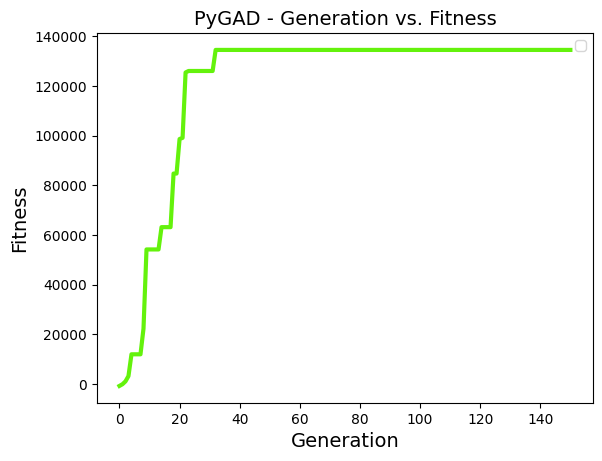

**************************************************
 GA-optimized pattern II (max final equity) full period:  [1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1]
 total return of optimal pattern:                         134,461.64


In [ ]:
# performing GA-optimisation, plotting fitness function
pr_w_run = price_w
ga_instance.run()
fig = ga_instance.plot_fitness()

# optimized pattern an best value fittnes function
pos_full_opt3, strat, strat_idx = ga_instance.best_solution()

print('**************************************************')
print(f' GA-optimized pattern II (max final equity) full period:  {pos_full_opt3.tolist()}')
print(f' total return of optimal pattern:                         {strat:,.2f}')

In [ ]:
# printing results
xx = np.roll(np.array(pos_orig), -shift_weeks).tolist()
print('*****************************************************************************************************')
print(f'GA optimized pattern II (max final equity = w fee, opt. during full period):  {pos_full_opt3.tolist()}')
print(f'GA optimized pattern II (max final equity = w fee, opt. during orig. period): {pos_orig_opt3.tolist()}')
print(f'detected pattern {limits[0]}  calc. during full period:                       {pos_full_opt11}')
print(f'detected pattern {limits[0]}  calc. during orig. period:                      {pos_orig_opt11}')
print(f'original pattern, shifted by {shift_weeks} wks.:                                         {xx}')

*****************************************************************************************************
GA optimized pattern II (max final equity = w fee, opt. during full period):  [1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1]
GA optimized pattern II (max final equity = w fee, opt. during orig. period): [1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, -1, -1]
detected pattern (0.5, -0.5)  calc. during full period:                       [1, 1, 1, -1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0]
detected pattern (0.5, -0.5)  calc. during orig. period:                      [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, -1]
original pattern, shifted by 12 wks.:                                         [1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0]


In [ ]:
# calculation for full period (2000-2024), optimizing the parameters during full intervall (2000-2024)
main_title = 'Equity for 16-weeks-cycle, various patterns: GA-optimized-II and detected (full period vs. original period only) (w fee)'
sub_title = 'instrument: DAX [2000-2024], applied parameters from optimisation in [2000-2024] or from [2000-2018]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# GA opt.pattern II (max final equity) optimized for full period --> positions, trades, equity
ps_full_opt3 = pos_weekly(price_w, pos_full_opt3, shift=0)
trades_full_opt3 = trading_journal(price_w, ps_full_opt3)
eq_full_opt3 = pnl_acc_real_equity(price_w, ps_full_opt3, start_equity, fee, fixed_fee)

# manually optimized pattern optimized for full period
ps_full_opt11 = pos_weekly(price_w, pos_full_opt11, shift=0)
trades_full_opt11 = trading_journal(price_w, ps_full_opt11)
eq_full_opt11 = pnl_acc_real_equity(price_w, ps_full_opt11, start_equity, fee, fixed_fee)

# plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=price_w.index, y=eq_full_opt3, name='GA-opt.pattern-II (max. final equity = w fee) optimized in full period'))
fig.add_trace(go.Scatter(x=price_w.index, y=eq_ext_opt3, name='GA-opt.-pattern-II (max. final equity = w fee) optimized in orig. period'))
fig.add_trace(go.Scatter(x=price_w.index, y=eq_full_opt11, name=f'detected pattern {limits[0]}, optimized in full period'))
fig.add_trace(go.Scatter(x=price_w.index, y=eq_ext_opt11, name=f'detected pattern {limits[0]}, optimized in orig. period'))
fig.update_layout(title=title, xaxis_title='date', yaxis_title='Equity' )
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=600)
fig.show()

# printing results
print(' ')
print('******************************************************************************')
print(f'Final Equity GA opt. pattern II (max final equity = w fee), opt. during full period:      {eq_full_opt3[-1]:,.1f}    {eq_full_opt3[-1]/start_equity*100:,.1f} %     number of trades: {len(trades_full_opt3)}')
print(f'Final Equity GA opt. pattern II (max final equity = w fee), opt. during orig period:      {eq_ext_opt3[-1]:,.1f}    {eq_ext_opt3[-1]/start_equity*100:,.1f} %      number of trades: {len(trades_ext_opt3)}')
print(f'Final Equity detected pattern {limits[0]}, opt. during full period:                       {eq_full_opt11[-1]:,.1f}      {eq_full_opt11[-1]/start_equity*100:,.1f} %      number of trades: {len(trades_full_opt11)}')
print(f'Final Equity detected pattern {limits[0]}, opt. during orig period:                       {eq_ext_opt11[-1]:,.1f}      {eq_ext_opt11[-1]/start_equity*100:,.1f} %      number of trades: {len(trades_ext_opt11)}')

 
******************************************************************************
Final Equity GA opt. pattern II (max final equity = w fee), opt. during full period:      134,461.6    1,344.6 %     number of trades: 317
Final Equity GA opt. pattern II (max final equity = w fee), opt. during orig period:      110,943.6    1,109.4 %      number of trades: 396
Final Equity detected pattern (0.5, -0.5), opt. during full period:                       54,848.3      548.5 %      number of trades: 396
Final Equity detected pattern (0.5, -0.5), opt. during orig period:                       60,850.0      608.5 %      number of trades: 317


In [ ]:
# DrawDowns
main_title = 'Drawdowns 16-weeks-cycle, different patterns:(GA-optimized-II, manually optimized-I (full period vs orig period))'
sub_title = 'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

xx0 = pd.Series(eq_full_opt3, index=price_w.index)
xx1 = pd.Series(eq_ext_opt3, index=price_w.index)
xx2 = pd.Series(eq_full_opt11, index=price_w.index)
xx3 = pd.Series(eq_ext_opt11, index=price_w.index)


x0 = ((xx0 / xx0.expanding().max()) - 1) * 100
x1 = ((xx1 / xx1.expanding().max()) - 1) * 100
x2 = ((xx2 / xx2.expanding().max()) - 1) * 100
x3 = ((xx3 / xx3.expanding().max()) - 1) * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x0.index, y=x0, mode='none', fill='tozeroy', fillcolor='rgba(0, 255, 0, 0.3)', name='GA-opt.-II (full period)'))
fig.add_trace(go.Scatter(x=x1.index, y=x1, mode='none', fill='tozeroy', fillcolor='rgba(255, 255, 0, 0.3)', name='GA-opt.-II (orig period)'))
fig.add_trace(go.Scatter(x=x2.index, y=x2, mode='none', fill='tozeroy', fillcolor='rgba(0, 0, 255, 0.3)', name=f'manually opt. {limits[0]}, full period'))
fig.add_trace(go.Scatter(x=x3.index, y=x3, mode='none', fill='tozeroy', fillcolor='rgba(0, 250, 54, 0.3)', name=f'manually opt. {limits[0]}, orig. period'))
fig.update_layout(template = 'plotly_dark',autosize=False, width=1200, height=400)
fig.update_layout(title=title, xaxis_title='date', yaxis_title='drawdown (%)')
fig.show()

m0, m1, m2, m3 = x0.min(), x1.min(), x2.min(), x3.min()
print(f'*************************************************')
print(f'max DrawDown GA-optimized pattern II (maximum final equity = w fee), optimized full period:       {m0:.1f}% ')
print(f'max DrawDown GA-optimized pattern II (maximum final equity = w fee), optimized orig. period:      {m1:.1f}% ')
print(f'max DrawDown manually optimized pattern {limits[0]}, optimized full period:                       {m2:.1f}% ')
print(f'max DrawDown manually optimized pattern {limits[0]}, optimized orig. period:                      {m3:.1f}% ')

*************************************************
max DrawDown GA-optimized pattern II (maximum final equity = w fee), optimized full period:       -24.4% 
max DrawDown GA-optimized pattern II (maximum final equity = w fee), optimized orig. period:      -32.8% 
max DrawDown manually optimized pattern (0.5, -0.5), optimized full period:                       -20.6% 
max DrawDown manually optimized pattern (0.5, -0.5), optimized orig. period:                      -36.2% 


In [ ]:
# gantt-chart of trading positions of various patterns
main_title = 'Position for 16-weeks-cycle, different patterns (GA-optimized-II, manually optimized, original)'
sub_title = 'instrument: DAX [2000-2024], optimized either during original period or during full period'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

mop1 = f'manually opt. pattern {limits[0]} (opt. orig period.)'
mop2 = f'manually opt. pattern {limits[0]} (opt. full period)'

various_trades = [trades_ext_orig, trades_ext_opt11, trades_full_opt11, trades_ext_opt3, trades_full_opt3]
labels = ['original pattern', mop1, mop2, 'GA-opt.-pattern-II (opt. orig. period)', 'GA-opt.-pattern-II (opt. full period)']
position_gantt(various_trades, labels, title)

## 2.4 Trade Statistics 16 weeks cycle with various GA optimized pattern

In [ ]:
# simulation of real conditions (incl. fee) and calculation of statistics
print('*** GA-optimized-pattern-II (max final equity w fee) (parameters optimized during [2000-2024]) ********************')
trade_key_parameters(trades_full_opt3, price_w)                         # key parameter independent from start_equity
trade_key_parameters2(trades_full_opt3, start_equity, fee, fixed_fee)   # key parameter depending on start_equity
print("")
print('*** GA-optimized-pattern-II (max final equity w fee) (parameters optimized during [2000-2018]) ********************')
trade_key_parameters(trades_ext_opt3, price_w)            # key parameter independent from start_equity
trade_key_parameters2(trades_ext_opt3, start_equity, fee, fixed_fee)    # key parameter depending on start_equity
print('*** GA-optimized-pattern-I (max final PnL w/o fee) (parameters optimized during [2000-2018]) **********************')
trade_key_parameters(trades_ext_opt2, price_w)          # key parameter independent from start_equity
trade_key_parameters2(trades_ext_opt2, start_equity, fee, fixed_fee)    # key parameter depending on start_equity
print('*** manually optimized-pattern II (parameters optimized during [2000-2024]) *******************************************')
trade_key_parameters(trades_full_opt11, price_w)          # key parameter independent from start_equity
trade_key_parameters2(trades_full_opt11, start_equity, fee, fixed_fee)    # key parameter depending on start_equity
print('*** original pattern (parameters optimized during [2000-2018]) *****************************************************')
trade_key_parameters(trades_ext_orig, price_w)          # key parameter independent from start_equity
trade_key_parameters2(trades_ext_orig, start_equity, fee, fixed_fee)    # key parameter depending on start_equity


*** GA-optimized-pattern-II (max final equity w fee) (parameters optimized during [2000-2024]) ********************
********************************************************
start date:  2000-01-03
end date:    2024-03-25
┌───────────────────────────┬──────────────┬────────┬─────────┬────────┐
│  Parameter                │   All Trades │   LONG │   SHORT │   FLAT │
├───────────────────────────┼──────────────┼────────┼─────────┼────────┤
│ duration (days):          │     8,848.00 │        │         │        │
├───────────────────────────┼──────────────┼────────┼─────────┼────────┤
│ nb of trades:             │       317.00 │ 159.00 │  158.00 │        │
├───────────────────────────┼──────────────┼────────┼─────────┼────────┤
│ duration of trades (%):   │       100.00 │  43.81 │   24.98 │  31.22 │
├───────────────────────────┼──────────────┼────────┼─────────┼────────┤
│ percent profitable (%):   │        63.41 │  71.07 │   55.70 │        │
├───────────────────────────┼──────────────┼─────

#3. Optimizing the weekly pattern within different N-week-cycles




## 3.1. Optimizing the final PnL (w/o fees)

### 3.1.1 Calculation via pattern detection

In [ ]:
# optimizing using the full period
pr_w_run = price_w
results_1a = pd.DataFrame(columns=['cycle', 'strat', 'pattern'])

# calculations

for cycle_length in tqdm(range(4,52)):
  df1, pos_x  = pattern_detection(pr_w_run, cycle_length, upper_limit=limits[0][0], lower_limit=limits[0][1])
  pnl_run = pnl_accumulation(pr_w_run,
                             pos_weekly(pr_w_run, pos_x, shift=0))
  strat = pnl_run[-1]
  results_1a.loc[len(results_1a.index)] = [cycle_length, strat, pos_x]

100%|██████████| 48/48 [00:00<00:00, 197.20it/s]


In [ ]:
# Display of the results
main_title = f'Final PnL for N-weeks-cycle, manually optimized patterns {limits[0]}, optimisation full period'
sub_title = 'instrument: DAX [2000-2024], (without fee)'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = px.bar(results_1a, x=results_1a['cycle'], y=results_1a['strat'])
fig.update_layout(title=title)
fig.update_layout(template = 'plotly_dark', autosize=False, width=1400, height=400)
fig.add_hline(y=pnl_full_buh[-1], line_dash='dot', line_color='green', annotation_text='Buy and Hold PnL', annotation_position='top left')
fig.update_layout(xaxis_title="cycle length [wks]", yaxis_title='final PnL')

#### 3.1.2  Optimisation using GA (max PnL = w/o fees)

In [ ]:
# optimizing using the full period
pr_w_run = price_w
# preparation of dataframe for storing results
results_1b = pd.DataFrame(columns=['cycle', 'strat', 'pattern'])
# looping through various cycles
for cycle_length in tqdm(range(4,52)):
  ga_instance = pygad.GA(num_generations=150,
                       num_parents_mating=4,
                       fitness_func=opt_pattern1,
                       sol_per_pop=8,
                       num_genes=cycle_length,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)
  ga_instance.run()
  pos, strat, strat_idx = ga_instance.best_solution()
  results_1b.loc[len(results_1b.index)] = [cycle_length, strat, pos]

100%|██████████| 48/48 [02:07<00:00,  2.66s/it]


In [ ]:
# Display of the results
main_title = 'Final PnL for N-weeks-cycle, manually vs GA-optimized patterns (max PnL = w/o fees)'
sub_title = 'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = go.Figure()
fig.add_trace(go.Bar(x=results_1a['cycle'], y=results_1a['strat'], name=f'manually optimized {limits[0]}'))
fig.add_trace(go.Bar(x=results_1b['cycle'], y=results_1b['strat'], name='GA-optimized'))
fig.update_layout(template = 'plotly_dark', autosize=False, width=1400, height=400)
fig.update_layout(title=title, xaxis_title="cycle length [wks]", yaxis_title='final PnL')
fig.update_xaxes(dtick=1)
fig.show()

###3.1.3 Results - Diagrams (for best fits)

In [ ]:
# selection of the best fits (manual fit)
best_fits = [16, 32, 33, 48]
list_pos_man = results_1a[results_1a.cycle.isin(best_fits)]
pos_list_man = list(list_pos_man['pattern'])
list_pos_ga = results_1b[results_1b.cycle.isin(best_fits)]
pos_list_ga = list(list_pos_ga['pattern'])


In [ ]:
# pnL curves of the best fits
main_title = 'PnL-curves for best fits cycles (w/o fee) manual-I  vs. GA optimisation'
sub_title = 'instrument: DAX [2000-2024], parameters optimized [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

print('********************************************')
fig = go.Figure()

## manually  optimized pattern
for i in range(0, len(best_fits)):
  pos_x = pos_list_man[i]
  pnl_x = pnl_accumulation(price_w,
                           pos_weekly(price_w, pos_x, shift=0))
  lb = f' {best_fits[i]} wks cycle lgt. manual optimisation {limits[0]}'
  fig.add_trace(go.Scatter(x=price_w.index, y=pnl_x, name=lb))
  print(f'{lb}:         {pnl_x[-1]:,.2f}')

## GA-optimized pattern
for i in range(0, len(best_fits)):
  pos_x = pos_list_ga[i]
  pnl_x = pnl_accumulation(price_w,
                           pos_weekly(price_w, pos_x, shift=0))
  lb = f' {best_fits[i]} wks cycle lgt. GA-optimisation-II'
  fig.add_trace(go.Scatter(x=price_w.index, y=pnl_x, name=lb))
  print(f'{lb}:                      {pnl_x[-1]:,.2f}')

print(' ')
fig.update_layout(title=title, xaxis_title='date', yaxis_title='PnL' )
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=600)
fig.show()


********************************************
 16 wks cycle lgt. manual optimisation (0.5, -0.5):         46.67
 32 wks cycle lgt. manual optimisation (0.5, -0.5):         118.42
 33 wks cycle lgt. manual optimisation (0.5, -0.5):         221.83
 48 wks cycle lgt. manual optimisation (0.5, -0.5):         370.42
 16 wks cycle lgt. GA-optimisation-II:                      87.15
 32 wks cycle lgt. GA-optimisation-II:                      187.77
 33 wks cycle lgt. GA-optimisation-II:                      312.87
 48 wks cycle lgt. GA-optimisation-II:                      566.77
 


In [ ]:
# gantt-chart of trading positions of various patterns
main_title = 'sequence of positions over time for best-fit-cycles (w/o fee)'
sub_title = 'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

selection = 0
various_trades = []
labels = []
for i in range(0, len(best_fits)):
  pos = pos_list_man[i]
  trades = trading_journal(price_w,
                           pos_weekly(price_w, pos, shift=0))
  task = f' cycle lgt. = {best_fits[i]} wks (manual optimized {limits[selection]})'
  various_trades.append(trades)
  labels.append(task)
for i in range(0, len(best_fits)):
  pos = pos_list_ga[i]
  trades = trading_journal(price_w,
                           pos_weekly(price_w, pos, shift=0))
  task = f' cycle lgt. = {best_fits[i]} wks (GA optimized-II)'
  various_trades.append(trades)
  labels.append(task)

position_gantt(various_trades, labels, title)

##3.2. Optimizing Final Equity (incl. fee)

### 3.2.1. Manual Optimisation

In [ ]:
# manual optimisation, looping through cycles
results_mopt = pd.DataFrame(columns=['cycle', 'selection', 'upper_limit', 'lower_limit', 'strat', 'pattern'])
# looping through cycles
for cycle_length in tqdm(range(4, 52)):
  # looping through various limits
  for i in range(len(limits)):
    # estimation of optimized pattern
    df1, pos_full_x = pattern_detection(price_w, cycle_length,
                                        upper_limit=limits[i][0],
                                        lower_limit=limits[i][1])
    ps_full_x = pos_weekly(price_w, pos_full_x, shift=0)
    eq_full_x = pnl_acc_real_equity(price_w, ps_full_x, start_equity, fee, fixed_fee)
    results_mopt.loc[len(results_mopt.index)] = [cycle_length, i, limits[i][0], limits[i][1], eq_full_x[-1], pos_full_x]

100%|██████████| 48/48 [00:02<00:00, 22.83it/s]


In [ ]:
main_title = f'Final equity for various N-weeks cycles and various detected patterns, w fee'
sub_title = 'instrument: DAX [2000-2024], various settings for filter in pattern detection'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'
fig = go.Figure()
for i in range(len(limits)):
  temp = results_mopt[results_mopt['selection'] == i]
  lb = f'detection [{limits[i]}]'
  fig.add_trace(go.Bar(x=temp['cycle'], y=temp['strat'], name = lb))

fig.add_hline(y=pnl_full_buh[-1] * start_equity, line_dash='dot', line_color='green', annotation_text='Buy and Hold PnL', annotation_position='top left')
fig.update_layout(template = 'plotly_dark', autosize=False, width=1400, height=400)
fig.update_layout(title=title, xaxis_title="cycle length [wks]", yaxis_title='Equity')
fig.update_xaxes(dtick=1)
fig.show()

### 3.2.2. GA optimisation for full period [4...52]

In [ ]:
# optimizing using the full period
# preparation of dataframe for storing results
results_ga_all = pd.DataFrame(columns=['cycle', 'strat', 'GA-pattern'])

# looping through all cycles
for cycle_length in tqdm(range(4,52)):
  ga_instance = pygad.GA(num_generations=200,
                       num_parents_mating=4,
                       fitness_func=opt_pattern2,
                       sol_per_pop=8,
                       num_genes=cycle_length,
                       gene_type=int,
                       gene_space=[-1, 0, 1],
                       mutation_percent_genes=10,
                       suppress_warnings=True)
  pr_w_run = price_w
  ga_instance.run()
  pos, strat, strat_idx = ga_instance.best_solution()
  results_ga_all.loc[len(results_ga_all.index)] = [cycle_length, strat, pos]

100%|██████████| 48/48 [02:42<00:00,  3.38s/it]


In [ ]:
# Display of the results
selection = 2
main_title = f'Final equity for N-weeks-cycle, detected {limits[selection]} vs GA-optimized patterns-II (max final equity) (w fees)'
sub_title =  f'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = go.Figure()
temp = results_mopt[results_mopt['selection'] == selection]
fig.add_trace(go.Bar(x=temp['cycle'], y=temp['strat'], name=f'manually optimized {limits[selection]}'))
fig.add_trace(go.Bar(x=results_ga_all['cycle'], y=results_ga_all['strat'], name='GA-optimized'))
fig.update_layout(template = 'plotly_dark', autosize=False, width=1400, height=400)
fig.update_layout(title=title, xaxis_title="cycle length [wks]", yaxis_title='final equity')
fig.update_xaxes(dtick=1)
fig.show()

In [ ]:
# Equity curves of the best fits
main_title = 'Equity-curves for best fits cycles (w fee)'
sub_title = 'instrument: DAX [2000-2024], parameters optimized [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

# manual selection of the best fit
best_fits = [16, 32, 33, 48]
selection = 2

print('**********************')
fig = go.Figure()
results_mo = results_mopt[results_mopt['selection'] == selection]

for i in range (len(best_fits)):
  cycle_length = best_fits[i]
  x = results_mo[results_mo['cycle']==cycle_length]
  pos_x = x['pattern'].tolist()[0]
  eq_x = pnl_acc_real_equity(price_w,
                             pos_weekly(price_w, pos_x, shift=0),
                             start_equity, fee, fixed_fee)
  lb = f' {best_fits[i]} wks cycle manual opt. {limits[selection]}'
  fig.add_trace(go.Scatter(x=price_w.index, y=eq_x, name=lb))
  print(f'{lb}:                      {eq_x[-1]:,.1f}')
  x = results_ga_all[results_ga_all['cycle']==cycle_length]
  pos_x = pos_x = x['GA-pattern'].tolist()[0]
  eq_x = pnl_acc_real_equity(price_w,
                             pos_weekly(price_w, pos_x, shift=0),
                             start_equity, fee, fixed_fee)
  lb = f' {best_fits[i]} wks cycle GA opt.-II (final equity)'
  fig.add_trace(go.Scatter(x=price_w.index, y=eq_x, name=lb))
  print(f'{lb}:                    {eq_x[-1]:,.1f}')

fig.update_layout(title=title, xaxis_title='date', yaxis_title='PnL' )
fig.update_layout(template = 'plotly_dark', autosize=False, width=1200, height=600)
print(' ')
fig.show()

**********************
 16 wks cycle manual opt. (0.2, -0.2):                      80,550.7
 16 wks cycle GA opt.-II (final equity):                    134,461.6
 32 wks cycle manual opt. (0.2, -0.2):                      331,042.0
 32 wks cycle GA opt.-II (final equity):                    328,126.9
 33 wks cycle manual opt. (0.2, -0.2):                      365,819.9
 33 wks cycle GA opt.-II (final equity):                    467,281.6
 48 wks cycle manual opt. (0.2, -0.2):                      648,870.2
 48 wks cycle GA opt.-II (final equity):                    374,716.5
 


In [ ]:
# gantt-chart of trading positions of various patterns
main_title = 'sequence of positions over time for best-fit-cycles (w fee)'
sub_title = 'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'
various_trades = []
labels = []
for i in range(0, len(best_fits)):
  cycle_length = best_fits[i]
  x = results_mo[results_mo['cycle']==cycle_length]
  pos_x = x['pattern'].tolist()[0]
  trades = trading_journal(price_w,
                           pos_weekly(price_w, pos_x, shift=0))
  task = f'{best_fits[i]} wks-cycle, manually optimized {limits[selection]}'
  various_trades.append(trades)
  labels.append(task)
  x = results_ga_all[results_ga_all['cycle']==cycle_length]
  pos_x = pos_x = x['GA-pattern'].tolist()[0]
  trades = trading_journal(price_w,
                           pos_weekly(price_w, pos_x, shift=0))
  task = f'{best_fits[i]} wks-cycle, GA-opt. II (final equity)'
  various_trades.append(trades)
  labels.append(task)

position_gantt(various_trades, labels, title)

# 4. Overfitting?

In [ ]:
# manual optimisation, looping through cycles ---> to check overfitting effects, analysees is extendet to 2 years
results_mopt = pd.DataFrame(columns=['cycle', 'selection', 'upper_limit', 'lower_limit', 'strat', 'pattern'])
# looping through cycles
for cycle_length in tqdm(range(4, 104)):
  # looping through various limits
  for i in range(len(limits)):
    # estimation of optimized pattern
    df1, pos_full_x = pattern_detection(price_w, cycle_length,
                                        upper_limit=limits[i][0],
                                        lower_limit=limits[i][1])
    ps_full_x = pos_weekly(price_w, pos_full_x, shift=0)
    eq_full_x = pnl_acc_real_equity(price_w, ps_full_x, start_equity, fee, fixed_fee)
    results_mopt.loc[len(results_mopt.index)] = [cycle_length, i, limits[i][0], limits[i][1], eq_full_x[-1], pos_full_x]

100%|██████████| 100/100 [00:01<00:00, 58.09it/s]


In [ ]:
# Display of the results
selection = 2
main_title = f'Final equity for N-weeks-cycle, detected {limits[selection]} (w fees)'
sub_title =  f'instrument: DAX [2000-2024]; (equity in log scale)'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = go.Figure()
temp = results_mopt[results_mopt['selection'] == selection]
fig.add_trace(go.Bar(x=temp['cycle'], y=temp['strat'], name=f'detected {limits[selection]}'))
fig.update_layout(template = 'plotly_dark', autosize=False, width=1400, height=400)
fig.update_layout(title=title, xaxis_title="cycle length [wks]", yaxis_title='final equity')
fig.update_yaxes(type="log")
fig.show()

In [ ]:
# Display of the results
selection = 2
main_title = f'Final equity for N-weeks-cycle, detected {limits[selection]} (w fees)'
sub_title =  f'instrument: DAX [2000-2024]'
title = main_title + '<br><br><sup>' + sub_title + '</sup>'

fig = go.Figure()
temp = results_mopt[results_mopt['selection'] == selection]
fig.add_trace(go.Bar(x=temp['cycle'], y=temp['strat'], name=f'detected {limits[selection]}'))
fig.update_layout(template = 'plotly_dark', autosize=False, width=1400, height=400)
fig.update_layout(title=title, xaxis_title="cycle length [wks]", yaxis_title='final equity')
fig.show()